In [2]:
#data prep
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pandas import Series
from matplotlib.patches import Circle
import seaborn as sns
from datetime import datetime,timedelta
import numpy  as np
import scipy.stats as stats
from sklearn.cluster import KMeans

zscore_limit = 3
def dataPrep():
    # get data
    dfCaudal = pd.read_excel(r'caudal.xlsx')
    dfCaudal = pd.DataFrame(dfCaudal, columns=['Tempo', 'Caudal'])
    
    # data setup
    dfCaudal['Tempo'] = pd.to_datetime(dfCaudal['Tempo'])
    dfCaudal['Caudal'] = pd.to_numeric(dfCaudal['Caudal'], errors='coerce')
    dfCaudal.set_index('Tempo', inplace=True)
    dfCaudal.dropna(inplace=True)
    
    dfCaudal['zscore'] = stats.zscore(dfCaudal.Caudal)
    dfCaudal['mean12'] = dfCaudal['Caudal'].rolling(12).mean()
    dfCaudal.loc[dfCaudal['zscore'] > zscore_limit, 'Caudal'] = dfCaudal['mean12']
    
    # add previous n values to collumn 
    n = 10
    for i in range(n):
        dfCaudal[f'prev_{i+1}'] = dfCaudal['Caudal'].shift(i+1)
   
    
    
    
    # split by invalid points - points where time diff is too big > 7
    dfCaudal['timediff'] = dfCaudal.index.to_series().diff()
    dfCaudal.dropna(inplace=True)
    dataSetCuts = dfCaudal[dfCaudal['timediff'] > timedelta(hours=7)]
    dfCaudal =  dfCaudal[dfCaudal['Caudal'] != 0]
    dataSetCuts = pd.concat([dfCaudal.head(1), dataSetCuts, dfCaudal.tail(1)])
    dataSetLists = []
    prev_row = None
    for index, row in  dataSetCuts.iterrows():
         if prev_row is None:
            prev_row = row
         else:
            dataSetLists.append(dfCaudal.loc[prev_row.name:row.name, :].copy())
            prev_row = row
    
    
    # get first and second derivative 
    for index, df in enumerate(dataSetLists):
        df['diff'] = df['Caudal'].diff()
        df['diff2'] = df['diff'].diff()
        df.dropna(inplace=True)
    return dataSetLists
dataSetList = dataPrep()

In [3]:
dataSetList

[                        Caudal    zscore     mean12     prev_1     prev_2  \
 Tempo                                                                       
 2020-01-02 12:26:52   6.700000 -0.074952   4.758333   6.990000   6.100000   
 2020-01-02 13:26:52   7.000000 -0.046434   5.041667   6.700000   6.990000   
 2020-01-02 14:26:52   6.600000 -0.084458   5.316667   7.000000   6.700000   
 2020-01-02 15:26:57   5.790000 -0.161456   5.524167   6.600000   7.000000   
 2020-01-02 16:26:57   5.500000 -0.189023   5.640833   5.790000   6.600000   
 ...                        ...       ...        ...        ...        ...   
 2020-11-02 03:29:58  59.706667  5.107703  59.706667  60.190000  62.690000   
 2020-11-02 04:29:58  58.323333  3.736942  58.323333  59.706667  60.190000   
 2020-11-02 05:29:58  56.573333  3.356704  56.573333  58.323333  59.706667   
 2020-11-02 06:29:58  54.790000  3.689413  54.790000  56.573333  58.323333   
 2020-11-06 12:30:10   6.010000 -0.140543  49.527500  54.790000 

C:\Users\Francisco\AppData\Local\Temp\ipykernel_38772\4211975025.py:51: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if row.name in modified_dates:
C:\Users\Francisco\AppData\Local\Temp\ipykernel_38772\4211975025.py:51: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if row.name in modified_dates:
C:\Users\Francisco\AppData\Local\Temp\ipykernel_38772\4211975025.py:51: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() =

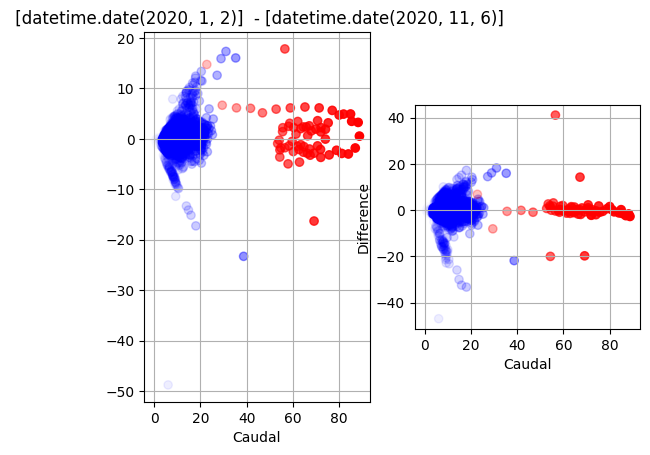

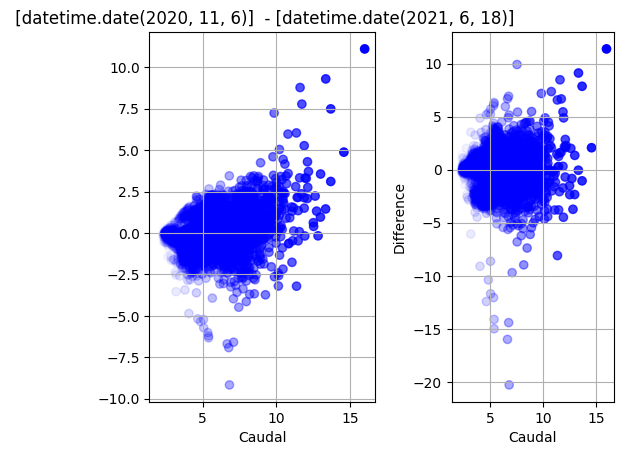

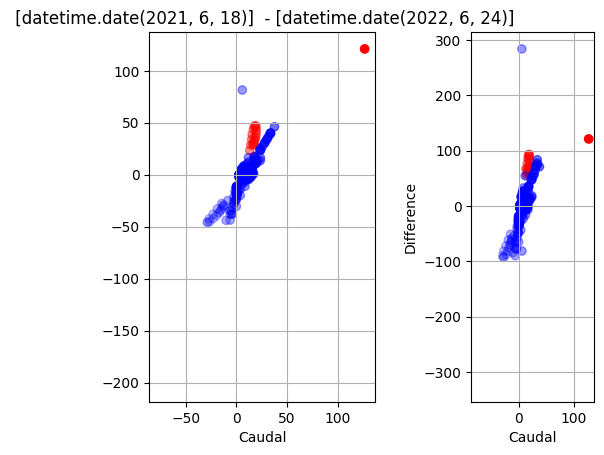

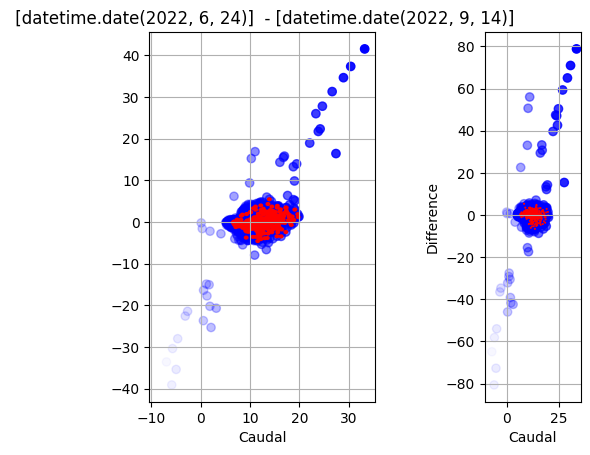

In [4]:
#get revelant dates 5 days before the exec
format_string = '%Y-%m-%d'
intervencaoDays = [
                   #'2022-05-26', '2022-05-20', '2022-05-19','2022-05-12',
                   '2022-07-01', '2022-07-08', '2022-08-04', '2022-08-29', '2022-10-07']
date_times = [datetime.strptime(date_string, format_string).date() for date_string in intervencaoDays]
modified_dates = []
for date in date_times:
    # subtract n days from the current date
    days = 5
    modified_date = date - timedelta(days=days)
    for i in range(days - 1):
        modified_dates.append(modified_date + timedelta(days=i+1))
#print(modified_dates)



for index, df in enumerate(dataSetList):
    colors = ['red' if df['zscore'][i] > zscore_limit else 'blue' for i in range(len(df))]
    min_value = df['Caudal'].min()
    max_value = df['Caudal'].max()
    df['Caudal_normalized'] = (df['Caudal'] - min_value) / (max_value - min_value)
    alpha_values = df['Caudal_normalized']
    
    dateStart = df.head(1).index.date
    dateEnd = df.tail(1).index.date
    title = f' {dateStart}  - {dateEnd}'
    
    fig, ax = plt.subplots(1, 2)
    # Plot the data in the first subplot
    ax[0].scatter(df['Caudal'], df['diff'], c = colors, alpha=alpha_values)
    ax[0].set_title(title)
    ax[0].set_xlabel('Caudal')
    # Add a grid to the first subplot
    ax[0].grid()
    
    #for i, txt in enumerate(df.index):
    #    if df['zscore'][i] > zscore_limit:
    #        ax[0].annotate(txt, (df['Caudal'][i], df['diff'][i]))
    
    # Plot the data in the second subplot
    ax[1].scatter(df['Caudal'], df['diff2'], c = colors,  alpha=alpha_values)

    ax[1].set_xlabel('Caudal')
    ax[1].set_ylabel('Difference')
    ax[1].set_aspect('equal')
    ax[1].grid()
    
    
    for i, row in df.iterrows():
        if row.name in modified_dates:
            #print(row)
            circ = Circle((row['Caudal'], row['diff']), radius=0.5, facecolor='red', alpha=1)
            ax[0].add_patch(circ)
                
            circ2 = Circle((row['Caudal'], row['diff2']), radius=0.5, facecolor='red', alpha=1)
            ax[1].add_patch(circ2)
            ax[1].set_aspect('equal')
        
       
    
plt.show()    

8.933704951759363 6.496692098287266
-0.0001390465380249756 1.8902760516418025
5.704203116200488 1.7971109200809023
0.0008278580814717474 1.0934345295611891


C:\Users\Francisco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Francisco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Francisco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

7.443398951659871 3.0207577449644996
0.000739662201514262 4.263883330404413
10.478256462240243 3.3635106293375054
-0.006771414090217915 3.6255201441129854


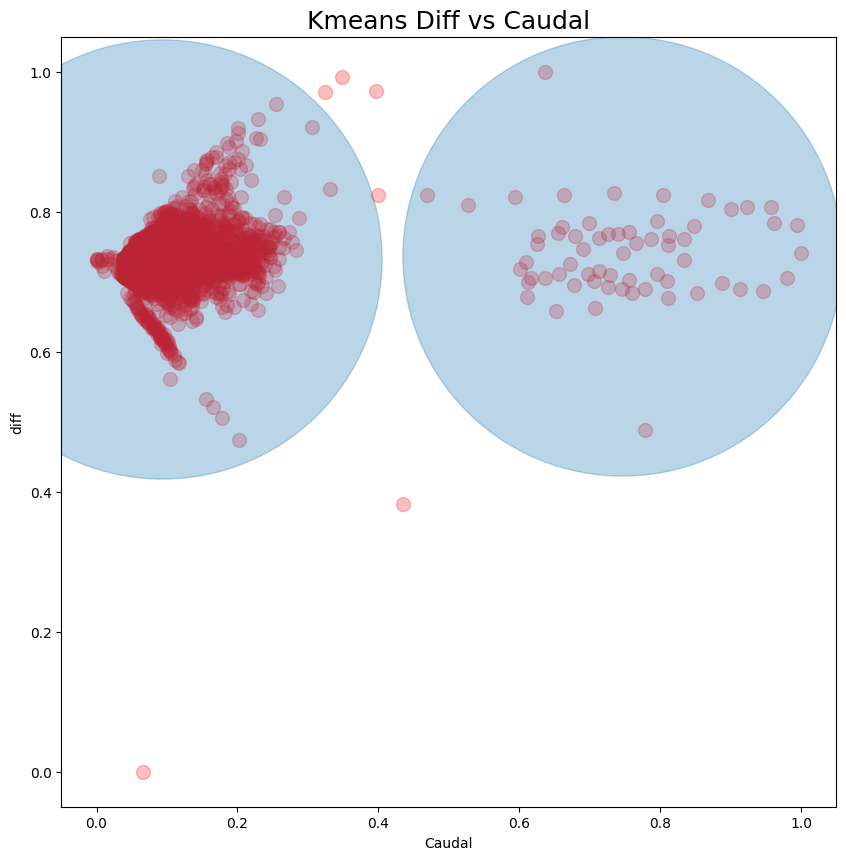

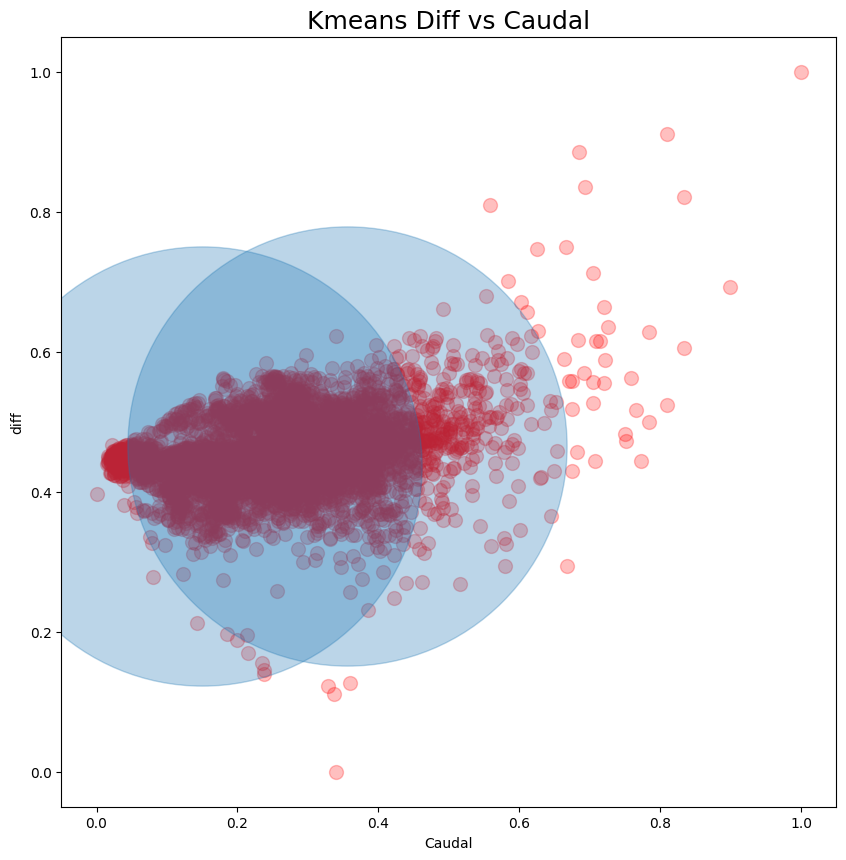

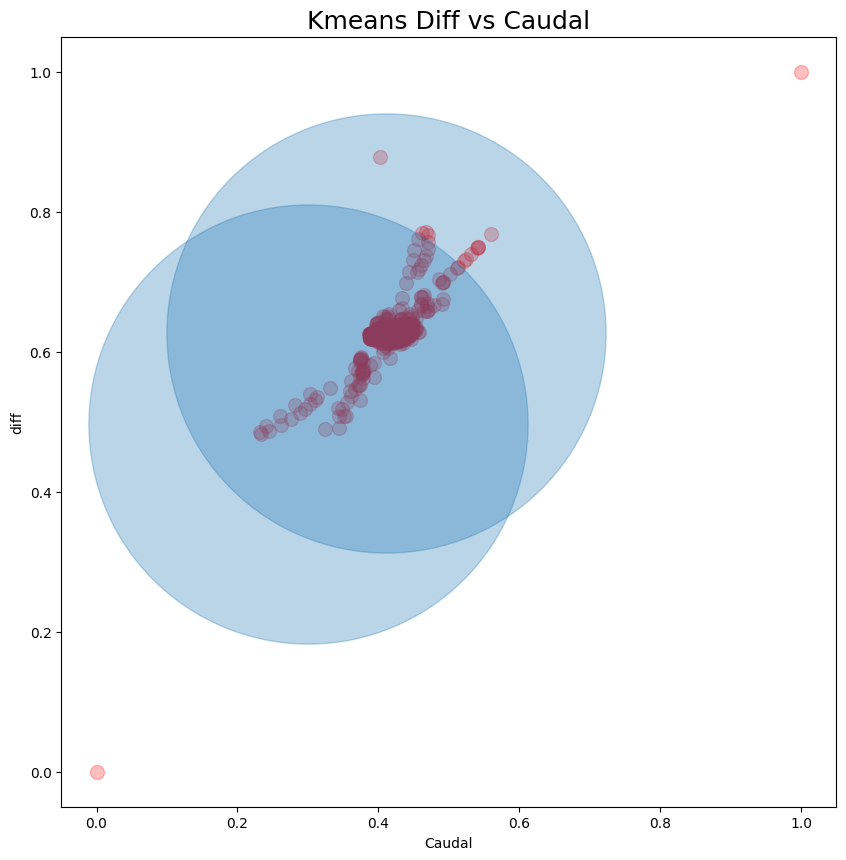

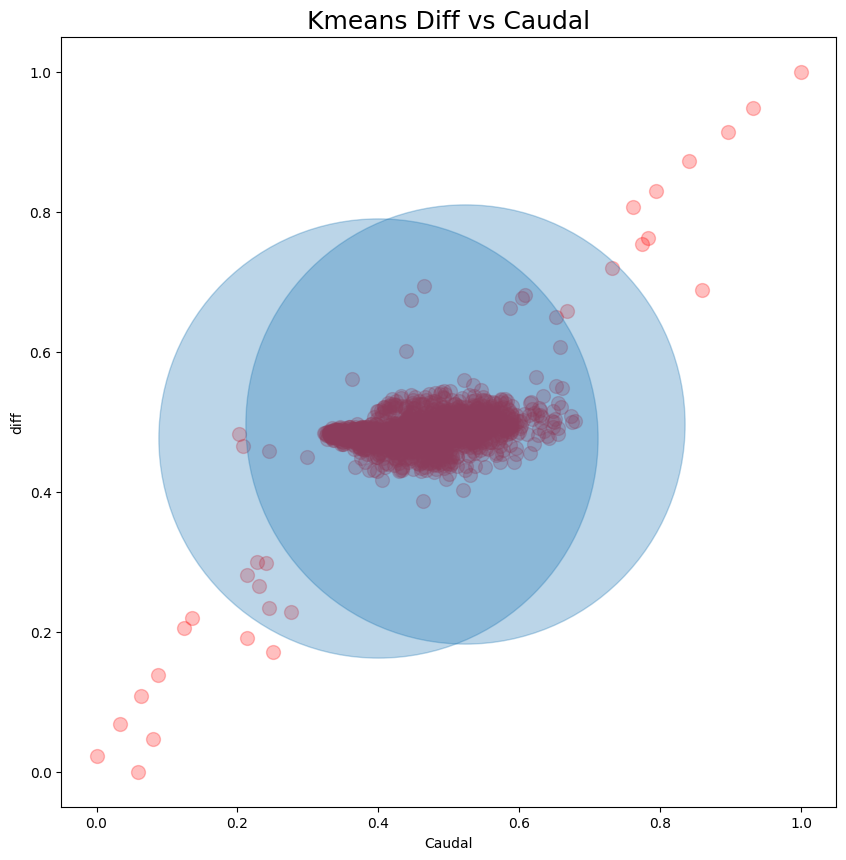

In [5]:
def scatterKmeans(df):
    # set the x and y variables
    col_x = 'Caudal'
    col_y = 'diff'

    x_mean = df[col_x].mean()
    x_stdev = df[col_x].std()

    y_mean = df[col_y].mean()
    y_stdev = df[col_y].std()

    print(x_mean, x_stdev)
    print(y_mean, y_stdev)

    # calculate the normalised values on x and y
    x_min = min(df[col_x])
    x_max = max(df[col_x])

    norm_x = ((df[col_x] - x_min)/(x_max - x_min))
    df['norm_x'] = norm_x

    y_min = min(df[col_y])
    y_max = max(df[col_y])

    norm_y = ((df[col_y] - y_min)/(y_max - y_min))
    df['norm_y'] = norm_y
    
    x_y = np.column_stack((df['norm_x'], df['norm_y']))
    km_res = KMeans(n_clusters=2).fit(x_y)
    clusters = km_res.cluster_centers_
    clusters

    figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')

    plt.xlabel(col_x)
    plt.ylabel(col_y)

    plt.scatter(df.norm_x, df.norm_y, alpha = 0.25, s = 100, color='red')
    plt.title("Kmeans Diff vs Caudal", fontsize=18)
    plt.scatter(clusters[:,0], clusters[:,1], s = 100000, alpha=0.30)
    


for index, df in enumerate(dataSetList):
    scatterKmeans(df)



In [6]:
def setSupervisedLearning(caudal):
    copyCaudal = caudal.copy()
    copyCaudal = copyCaudal.drop(columns=['Caudal', 'Caudal_normalized', 'norm_x', 'norm_y','timediff'])
    #cau['Weekday'] = cau.index.dayofweek
    #cau['month'] = cau.index.month
    # no data = '2022-06-13','2022-06-20', '2022-06-27',
    #print(modified_dates)
    copyCaudal['Y'] = [1 if row in modified_dates else 0 for row in copyCaudal.index.date]
    
    #cau = cau.loc[cau.index < '2022-6-09']
    copyCaudal.dropna(inplace=True)
    return copyCaudal


supervisedList = []
for index, df in enumerate(dataSetList):
    supervisedList.append(setSupervisedLearning(df))

In [7]:
supervisedList[-1]

,zscore,mean12,prev_1,prev_2,prev_3,prev_4,prev_5,prev_6,prev_7,prev_8,prev_9,prev_10,diff,diff2,Y
Tempo,,,,,,,,,,,,,,,
2022-06-24 23:37:09,0.368026,12.310000,13.44,14.96,10.19,10.44,11.81,11.48,11.05,11.54,12.24,15.27,-2.08,-0.56,0
2022-06-25 00:36:59,0.335706,12.066667,11.36,13.44,14.96,10.19,10.44,11.81,11.48,11.05,11.54,12.24,-0.34,1.74,0
2022-06-25 01:36:59,0.315744,11.695000,11.02,11.36,13.44,14.96,10.19,10.44,11.81,11.48,11.05,11.54,-0.21,0.13,0
2022-06-25 02:36:59,0.300534,11.562500,10.81,11.02,11.36,13.44,14.96,10.19,10.44,11.81,11.48,11.05,-0.16,0.05,0
2022-06-25 03:36:59,0.263461,11.455833,10.65,10.81,11.02,11.36,13.44,14.96,10.19,10.44,11.81,11.48,-0.39,-0.23,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-14 07:37:34,-0.055940,7.597500,6.33,6.57,6.01,6.05,6.10,6.68,6.97,8.21,9.56,11.37,0.57,0.81,0
2022-09-14 08:37:35,-0.324008,7.069167,6.90,6.33,6.57,6.01,6.05,6.10,6.68,6.97,8.21,9.56,-2.82,-3.39,0
2022-09-14 09:37:35,-0.534090,6.277500,4.08,6.90,6.33,6.57,6.01,6.05,6.10,6.68,6.97,8.21,-2.21,0.61,0


In [10]:
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.metrics import confusion_matrix,recall_score, precision_score, accuracy_score, f1_score

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


In [11]:
def getMetrics(Y_test, prediction_test):
     
    # metrics
    print("Accuracy = ", metrics.accuracy_score(Y_test, prediction_test))
    print("recall_score = ", metrics.recall_score(Y_test, prediction_test))
    print("precision_score = ", metrics.precision_score(Y_test, prediction_test))
    print("f1_score = ", metrics.f1_score(Y_test, prediction_test))
    
    # Calculate the TPR and FPR at different classification thresholds
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, prediction_test)
    # Calculate the AUC
    auc = metrics.auc(fpr, tpr)

    print("TPR:", tpr)
    print("FPR:", fpr)
    print("AUC:", auc)

In [29]:
def train(caudal):
    data = caudal.copy()
    Y = data['Y']
    Y = Y.astype('int')
    X = data.drop(labels=['Y'], axis=1)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.40, random_state=30)
    model = RandomForestClassifier(n_estimators= 8000, random_state=30, n_jobs=-1)
    model.fit(X_train, Y_train)
    
    feature_list = list(X.columns)
    feature_imp = pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False)
    print(feature_imp)
    return model

bestModel = train(supervisedList[-1])

mean12     0.129736
zscore     0.077834
prev_3     0.076724
prev_2     0.076506
prev_1     0.076394
prev_4     0.067949
prev_5     0.066046
prev_9     0.064172
prev_7     0.064149
prev_6     0.062502
prev_10    0.061631
prev_8     0.060667
diff2      0.057953
diff       0.057736
dtype: float64


In [35]:

def predict(data, model):
    caudal = data.copy()
    Y = caudal['Y']
    Y = Y.astype('int')
    X = caudal.drop(labels=['Y'], axis=1)
    #print(X)
    prediction_test = model.predict(X)
    #conf_matrix = confusion_matrix(Y, prediction_test)
    # Use matplotlib to create a heatmap of the confusion matrix
    #plt.imshow(conf_matrix, cmap='binary')
    #plt.colorbar()
    #getMetrics(Y, prediction_test)
    print(prediction_test)
    return prediction_test

#  todo fazer medias dos ultimos n dias em cada row 

In [37]:

for index, df in enumerate(supervisedList):
    supervisedList[index]['Y_pred'] = predict(supervisedList[index], bestModel)


[0 0 0 ... 1 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


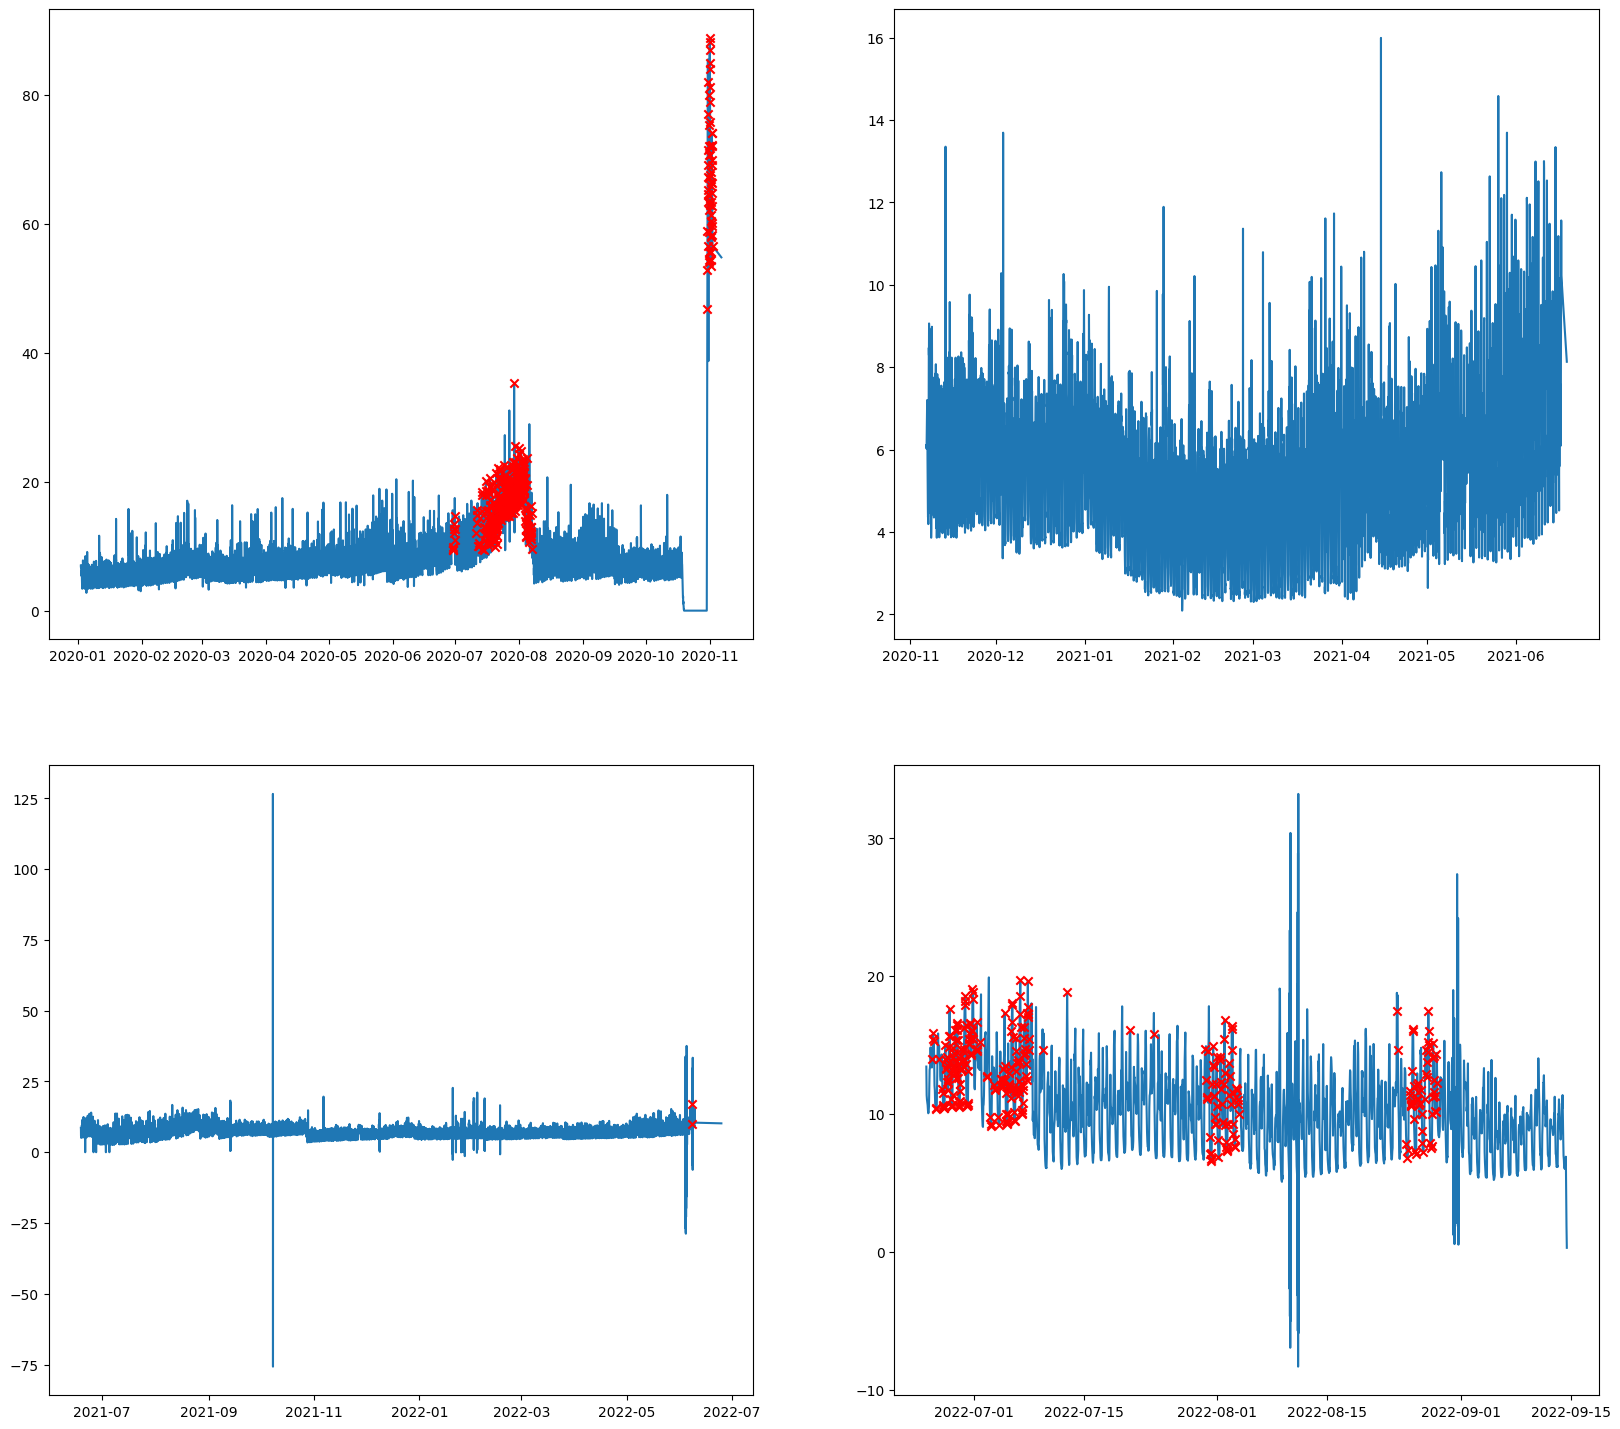

In [59]:
# todo remove 0 caudal in supervised [0] - correr novamente o timediff splitter, pois ha buracos com caudal 0


fig, axs = plt.subplots(2, 2)
fig.set_size_inches(20, 18)
fig.set_dpi(100)

# Iterate over the list of data frames and the subplots
for df, ax in zip(supervisedList, axs.flatten()):
    # Plot the 'prev_1' column of the data frame on the current subplot
    ax.plot(df.index, df['prev_1'])
    mask = df['Y_pred'] == 1
    x = df[mask].index
    y = df[mask]['prev_1']
    ax.scatter(x, y, c='r', marker='x', zorder=2)

# Show the plot
plt.show()





#supervisedList[0]['Y_pred']